In [ ]:
!git clone "https://github.com/Ankushdas178/bengali-abusive-comment-detection"

Cloning into 'bengali-abusive-comment-detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 31.91 KiB | 1.88 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Load datasets
abusive_df = pd.read_csv('/content/bengali-abusive-comment-detection/Abusive_Merged_Classes-new.csv')
non_abusive_df = pd.read_csv('/content/bengali-abusive-comment-detection/Non_abusive - Sheet1.csv')

In [ ]:
# Standardize column names for consistency
abusive_df.columns = ['Comment', 'Class']
non_abusive_df.columns = ['Comment', 'Class']
# Combine datasets and replace NaN in non-abusive with "Non abusive"
# Ensure no missing values in the 'Class' column for the non-abusive dataset
non_abusive_df['Class'].fillna('Non abusive', inplace=True)

# Combine the datasets
df = pd.concat([abusive_df, non_abusive_df], ignore_index=True)

<ipython-input-3-127803c9cec8>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  non_abusive_df['Class'].fillna('Non abusive', inplace=True)


In [ ]:
# Verify and ensure no missing values or unexpected classes
df['Class'] = df['Class'].fillna('Non abusive')  # Fill any remaining NaN values
assert df['Class'].isna().sum() == 0, "There are still missing values in the 'Class' column."


In [ ]:
# Preprocessing
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Lowercase the text
    text = text.lower()
    return text

# Apply the clean_text function
df['Comment'] = df['Comment'].apply(clean_text)

In [ ]:
# Encode labels dynamically based on unique classes in the dataset
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])
num_classes = len(label_encoder.classes_)


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['Comment'])
sequences = tokenizer.texts_to_sequences(df['Comment'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Class'], test_size=0.2, random_state=42)

# BLSTM Model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Use num_classes for the output layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 335ms/step - accuracy: 0.3411 - loss: 1.1005 - val_accuracy: 0.3380 - val_loss: 1.0971
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 13s 478ms/step - accuracy: 0.4187 - loss: 1.0905 - val_accuracy: 0.3944 - val_loss: 1.0793
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 0.6373 - loss: 1.0144 - val_accuracy: 0.6385 - val_loss: 0.9857
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.8415 - loss: 0.5686 - val_accuracy: 0.6197 - val_loss: 0.8508
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.9305 - loss: 0.2764 - val_accuracy: 0.6620 - val_loss: 1.0064


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Ensure that target names are strings
target_names = [str(label) for label in label_encoder.classes_]
print(classification_report(y_test, y_pred_classes, target_names=target_names))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
                precision    recall  f1-score   support

Gender abusive       0.84      0.65      0.73        80
   Non abusive       0.65      0.65      0.65        62
 Personal Hate       0.55      0.69      0.61        71

      accuracy                           0.66       213
     macro avg       0.68      0.66      0.66       213
  weighted avg       0.69      0.66      0.67       213



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate overall precision, recall, and F1 score
overall_precision = precision_score(y_test, y_pred_classes, average='weighted')
overall_recall = recall_score(y_test, y_pred_classes, average='weighted')
overall_f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Overall Precision: {overall_precision:.2f}")
print(f"Overall Recall: {overall_recall:.2f}")
print(f"Overall F1 Score: {overall_f1:.2f}")

Overall Precision: 0.69
Overall Recall: 0.66
Overall F1 Score: 0.67


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


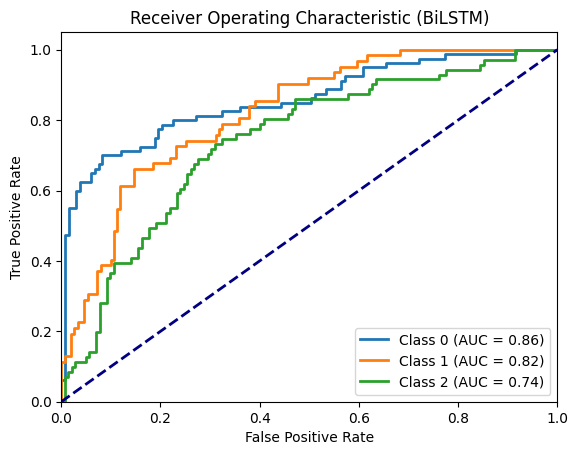

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Replace with your classes
n_classes = y_test_binarized.shape[1]

# Train One-vs-Rest Classifier
y_probs = model.predict(X_test)  # Assumes model supports `predict_proba`

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (BiLSTM)')
plt.legend(loc="lower right")
plt.show()


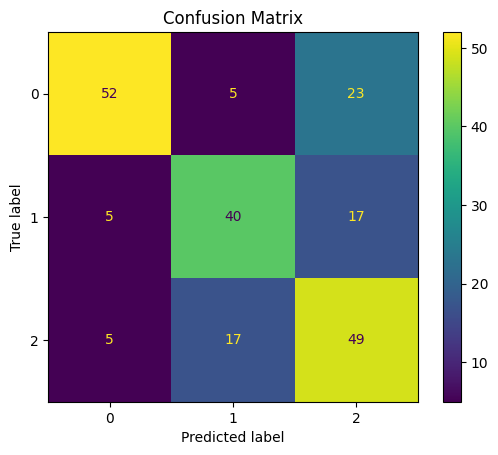

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert y_test to class labels if it is one-hot encoded
if y_test.ndim == 2:  # Check if y_test is one-hot encoded
    y_true_classes = np.argmax(y_test, axis=1)
else:
    y_true_classes = y_test

# Convert y_pred to class labels if it contains probabilities
if y_pred.ndim == 2:  # Check if y_pred contains probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)
else:
    y_pred_classes = y_pred

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
